In [1]:
import pandas as pd
import shap
import joblib
from keras.models import load_model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-04-17 16:49:37.599090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('best_model/engineered_data.csv')

In [3]:
dnn = load_model('best_model/best_model.keras')
prep = joblib.load('best_model/best_preprocssor.joblib')

In [4]:
X = df.drop(['Salary'], axis = 1)
y = df['Salary']

In [5]:
X_prep = prep.transform(X)

In [6]:
from sklearn.metrics import mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = .25, random_state = 621)

In [8]:
test_preds = dnn.predict(X_test)
train_preds = dnn.predict(X_train)

train_rmse = mean_squared_error(y_train, train_preds)
test_rmse = mean_squared_error(y_test, test_preds)

print('Deep Neural Network Metrics:')
print(f'Train RMSE: {np.sqrt(train_rmse)}')
print(f'Test RMSE: {np.sqrt(test_rmse)}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Deep Neural Network Metrics:
Train RMSE: 2783352.93212804
Test RMSE: 4271836.733430569


In [9]:
for layer in dnn.layers:
    print(layer.name)
    if 'dropout' in layer.name.lower():
        print("Dropout Rate:", layer.rate)  # Dropout rate
    if 'dense' in layer.name.lower():
        print("Number of Neurons:", layer.units)

optimizer = dnn.optimizer
lr = optimizer.learning_rate.numpy()
print(lr)


Dense1
Number of Neurons: 190
Dropout1
Dropout Rate: 0.4753571532049581
Dense2
Number of Neurons: 166
Dropout2
Dropout Rate: 0.4753571532049581
Output
0.60510385


In [11]:
expected_value = dnn.predict(X_prep).mean()

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [12]:
explainer = shap.Explainer(dnn, X_prep)

In [13]:
shap_values = explainer.shap_values(X_prep)

Permutation explainer: 5062it [23:14,  3.62it/s]                          


In [14]:
exp = shap.Explanation(shap_values, expected_value, X_prep, feature_names = prep.get_feature_names_out())

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


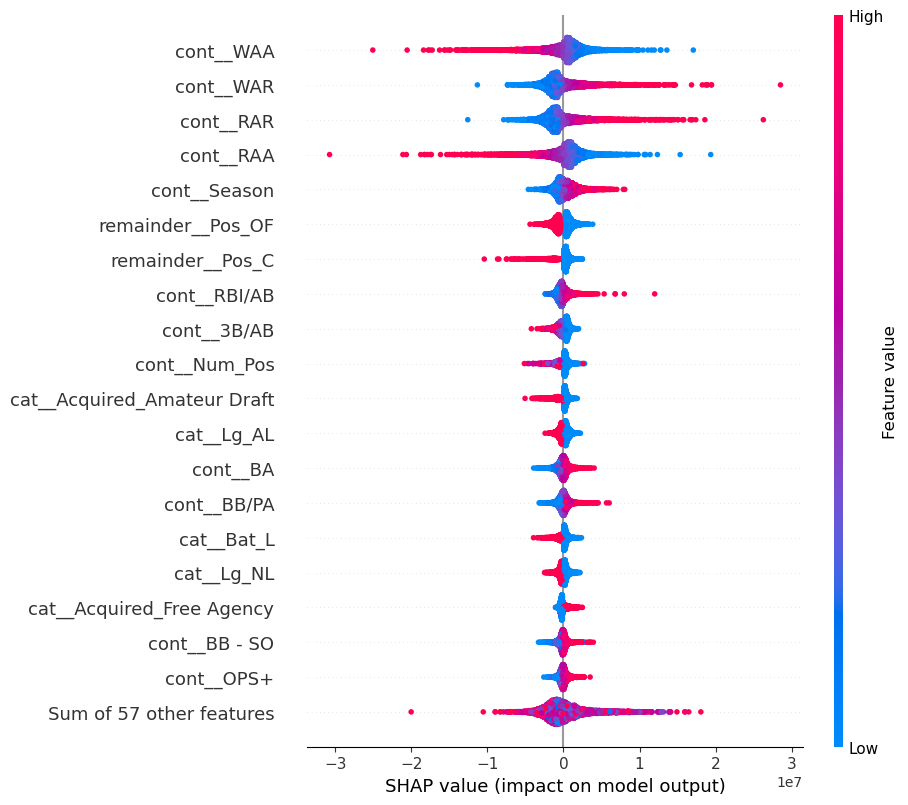

In [16]:
shap.plots.beeswarm(exp, max_display = 20)

In [17]:
import matplotlib.pyplot as plt

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


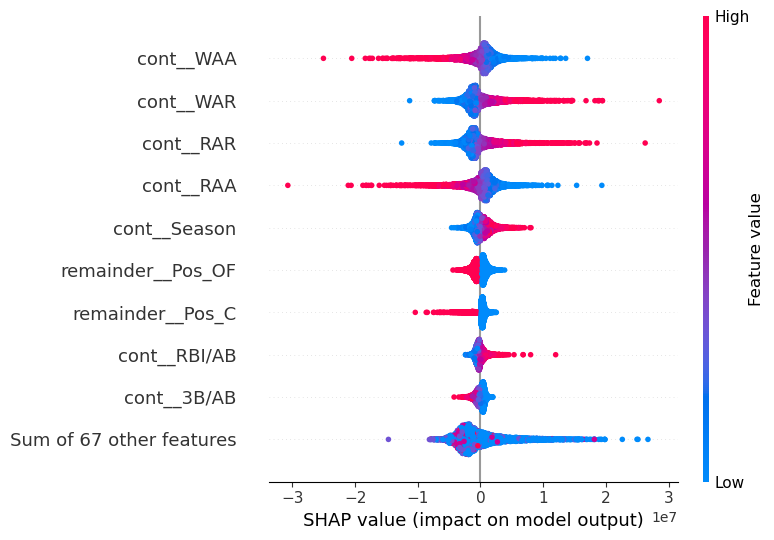

In [22]:
shap.plots.beeswarm(exp, max_display = 10, show = False)
plt.tight_layout()
plt.savefig('images/beeswarm.png')